In [1]:
import numpy as np 
import pandas as pd 
import csv 
%matplotlib inline 
import matplotlib.pyplot as plt 
import scipy.stats

### Load and view data 

In [2]:
# Load data
clinical = pd.read_csv("clinical.tsv", sep='\t', header=0) # if there is a header
fpkm = pd.read_csv("fpkm.tsv", sep='\t', header=0)
variants = pd.read_csv("variants.tsv", sep='\t', header=0)

In [3]:
# Check number of samples and features
print("Clinical data:")
print("No. samples:", clinical.shape[0])
print("No. features:", clinical.shape[1])

print("\nExpression (FKPM) data:")
print("No. samples:", fpkm.shape[0])
print("No. features:", fpkm.shape[1])

print("\nVariant data:")
print("No. samples:", variants.shape[0])
print("No. features:", variants.shape[1])


Clinical data:
No. samples: 144
No. features: 10

Expression (FKPM) data:
No. samples: 4523693
No. features: 3

Variant data:
No. samples: 317349
No. features: 9


In [4]:
# View data
# clinical.head()

# Assess the feature data types
clinical.dtypes

subject.id                       object
sample.tumor.type                object
sample.freetext.anatomic.site    object
timepoint.id                     object
meddra.disease.preferred.name    object
treatment.regimen.name           object
bor                              object
pfs                               int64
os                                int64
previous                         object
dtype: object

In [5]:
clinical['sample.tumor.type'].unique() # note that uveal data is missing

array(['cutaneous', 'acral', 'unknown', 'mucosal'], dtype=object)

In [6]:
# View categories for select features
clinical['sample.freetext.anatomic.site'].unique()
clinical['sample.tumor.type'].unique()
clinical['previous'].unique() # patient had previous PD1 inibitor treatment? naive == no/0; ctla4 = yes/1

array(['naive', 'ctla4'], dtype=object)

In [7]:
# View feature data types
fpkm.dtypes

subject.id           object
gene.hgnc.symbol     object
value               float64
dtype: object

In [8]:
# Check number of patients in this data set
print("No patients:", len(fpkm["subject.id"].unique())) # note: not all 144 patients are present

No patients: 121


In [9]:
# View feature data types
variants.dtypes

subject.id                 object
variant.id                 object
variant.ref.allele         object
variant.alt.allele         object
gene.hgnc.symbol           object
variant.HGVSp              object
aa.change                  object
collapsed.consequences     object
vaf                       float64
dtype: object

In [10]:
print("No patients:", len(variants["subject.id"].unique()))

No patients: 144


In [11]:
# View: types of consequences due to variant, ensembl format
variants["collapsed.consequences"].unique()

array(['intron_variant', 'missense_variant', 'splice_region_variant',
       'upstream_gene_variant', 'non_coding_transcript_exon_variant',
       'synonymous_variant', '5_prime_UTR_variant', 'stop_gained',
       '3_prime_UTR_variant', 'splice_donor_variant',
       'frameshift_variant', 'downstream_gene_variant',
       'stop_retained_variant', 'splice_acceptor_variant',
       'inframe_deletion', 'mature_miRNA_variant', 'start_lost',
       'inframe_insertion', 'stop_lost',
       'incomplete_terminal_codon_variant'], dtype=object)

## Data cleaning 

### Clinical data

**Edit subject.id column name**: There are 144 total subjects. Each patient as a unique subject ID that should be consistent among the three data sets in order to join them. The subject.id in the 'Clinical' data set appears to have 'extra' text appended at the end, i.e. '_liu', which we will remove as a new subject.id.edit column. I've chosen to make a new column so that the original subject.id is kept.

In [12]:
# Remove '_liu' string at end of subject.id
clinical["subject.id.edit"] = clinical["subject.id"].astype('str').map(lambda x: x.rstrip('_liu'))

# Rename columns
clinical.rename(columns={"subject.id": "subject.id.original"}, inplace = True)
clinical.rename(columns={"subject.id.edit": "subject.id"}, inplace = True)

# Check that subject IDs are unique
print("Any duplicated IDs?:", any(clinical["subject.id"].duplicated())) # False
print("Same no. IDs:", len(clinical["subject.id.original"].unique()) == len(clinical["subject.id"].unique())) # True

Any duplicated IDs?: False
Same no. IDs: True


### FPKM data

1. **Identify missing patient data**: We saw above that there are 121 unique subject.id in the FPKM data set, meaning that there is missing data from 23 patients. For our records, we will identify these 23 patients by cross-referencing against the Clinical and Variants data sets.

In [13]:
# Save subject.id to list
fpkm_sub = fpkm["subject.id"].to_list()
clinical_sub = clinical["subject.id"].to_list()
var_sub = variants["subject.id"].to_list()

In [14]:
# Find non-overlapping subject.id in FPKM against Clinical or Variants data
fpkm_vs_clin = set(fpkm_sub).symmetric_difference(clinical_sub)
fpkm_vs_var = set(fpkm_sub).symmetric_difference(var_sub)

print("Are missing patient lists the same?", fpkm_vs_clin == fpkm_vs_var) # True
print("Which patients are missing?", fpkm_vs_var)

Are missing patient lists the same? True
Which patients are missing? {'Patient157', 'Patient84', 'Patient182', 'Patient120', 'Patient59', 'Patient100', 'Patient110', 'Patient43', 'Patient41', 'Patient104', 'Patient54', 'Patient50', 'Patient55', 'Patient49', 'Patient118', 'Patient88', 'Patient180', 'Patient46', 'Patient119', 'Patient80', 'Patient39', 'Patient136', 'Patient60'}


2. **Reshape FPKM data**: For our analysis, we will merge patient and gene expression data by an inner join on Subject ID. However, all 121 patients had duplicate gene entries, e.g. multiple FPKM values for a gene. We first removed duplicated genes because I could not estimate which value should be correct. Then the data was 'widened'.

In [15]:
# Determine number of duplicate genes for each patient
f_data = fpkm.copy()

sub_id_fpkm = set(fpkm_sub) 
multiple_genes = []

for subject in sub_id_fpkm:
    patient = f_data[f_data['subject.id'] == subject]
    num_multiple = len(patient['gene.hgnc.symbol']) - len(patient['gene.hgnc.symbol'].unique())
    multiple_genes.append((subject, num_multiple))

In [16]:
# View number of duplicate genes for some patients
for i in range(10):
    print(multiple_genes[i][0], multiple_genes[i][1])

Patient99 50
Patient183 37
Patient48 47
Patient67 47
Patient10 49
Patient94 52
Patient17 50
Patient72 52
Patient147 51
Patient117 53


In [17]:
# Taking a closer look at one patient as an example

patient_167 = f_data[f_data['subject.id'] == 'Patient167'] # subset to Patient 167
patient_167_genes = patient_167['gene.hgnc.symbol'].to_list()
patient_167_dup_genes = set([x for x in patient_167_genes if patient_167_genes.count(x) > 1]) # find duplicated genes

print(patient_167_dup_genes)

f_data[(f_data['subject.id'] == 'Patient167') & (f_data['gene.hgnc.symbol'] == 'TBCE')]

{'H2BFS', 'LINC-PINT', 'SOD2', 'DNAJC9-AS1', 'ATXN7', 'CCDC39', 'SCO2', 'LINC01505', 'IPO5P1', 'ZNF503', 'GUSBP9', 'MATR3', 'POLR2J3', 'TMSB15B', 'RAET1E-AS1', 'SNHG28', 'HOXC5', 'IGF2', 'ALG1L9P', 'DIABLO', 'PRSS50', 'PKD1P1', 'POLR2J4', 'GOLGA8M', 'ITFG2-AS1', 'ZNF883', 'RNA5-8SN2', 'SNORA16A', 'PINX1', 'SCARNA4', 'SNORD3D', 'SNORA50A', 'TBCE', 'CYB561D2', 'KBTBD11-OT1', 'LINC01238', 'ELFN2', 'RGS5', 'RMRP', 'DUXAP8', 'SNORA17B', 'SNORD38B', 'SPATA13', 'HSPA14', 'SNX29P2', 'PDE11A'}


,subject.id,gene.hgnc.symbol,value
1705141,Patient167,TBCE,2.199433
1718828,Patient167,TBCE,8.146019


In [18]:
# Keep largest FPKM value for genes with more than one value reported
fpkm.sort_values(by=['subject.id', 'gene.hgnc.symbol', 'value'], inplace=True) # sort rows

fpkm_drop =  fpkm.drop_duplicates(subset=['subject.id', 'gene.hgnc.symbol'], keep='last') #keep = False (drop all), 'last' (higher value)
print("No. entries removed:", len(fpkm) - len(fpkm_drop))

# Check that the highest FPKM value was kept
print(f_data[(f_data['subject.id'] == 'Patient167') & (f_data['gene.hgnc.symbol'] == 'TBCE')]) # duplicates present
print(fpkm_drop[(fpkm_drop['subject.id'] == 'Patient167') & (fpkm_drop['gene.hgnc.symbol'] == 'TBCE')]) # duplicates removed

No. entries removed: 5795
         subject.id gene.hgnc.symbol     value
1705141  Patient167             TBCE  2.199433
1718828  Patient167             TBCE  8.146019
         subject.id gene.hgnc.symbol     value
1718828  Patient167             TBCE  8.146019


In [19]:
# Reshape fpkm data: patients (rows), genes (columns/features)

fpkm_wide = fpkm_drop.pivot(index='subject.id', columns='gene.hgnc.symbol', values='value')

fpkm_wide.shape # (121, 37338)

(121, 37338)

### Merge Clinical and FPKM data

In [20]:
# Merge Clinical and FPKM data
clinical_fkpm = clinical.join(fpkm_wide, on='subject.id')
clinical_fkpm.shape #(144, 37334)


(144, 37349)

In [21]:
# Convert BOR status from categorical to numerical value
new_label = {'PD':0,
             'PR':1,
             'SD':2,
             'CR':3}

bor_label, subject_list = [],[]
for i in clinical_fkpm['bor']:
    bor_label.append(new_label[i])
    
# Add new column of BOR numerical value 
clinical_fkpm.loc[:,'bor_numeric'] = pd.Series(bor_label, index=clinical_fkpm.index)

In [22]:
# Convert 'previous' categorical value to numeric values (one-hot encoding)
clinical_fkpm = pd.get_dummies(clinical_fkpm, columns = ['previous'], prefix_sep='_', drop_first=True)
# clinical_fkpm_dum = pd.get_dummies(clinical_fkpm, columns = ['sample.freetext.anatomic.site', 'sample.tumor.type'], prefix_sep='_', drop_first=True)


In [23]:
clinical_fkpm['sample.tumor.type'].unique()

array(['cutaneous', 'acral', 'unknown', 'mucosal'], dtype=object)

### Which genes are associated with each BOR status? 

In [24]:
# Is there a correlation between BOR status and previous PD-1 inhibitor treatment? No 
scipy.stats.pearsonr(clinical_fkpm['bor_numeric'], clinical_fkpm['previous_naive']) # Coeff: 0.08215403824068997, p-value: 0.3276233113723438

(0.08215403824068997, 0.3276233113723438)

#### Which genes are associated with cutaneous tumor type?

In [25]:
cutaneous_data = clinical_fkpm[clinical_fkpm['sample.tumor.type'] == 'cutaneous']
cutaneous_data = cutaneous_data.drop(['subject.id.original', 'sample.tumor.type', 'sample.freetext.anatomic.site', 'timepoint.id',
                                      'meddra.disease.preferred.name', 'treatment.regimen.name', 'bor', 'pfs', 'os', 'subject.id', 
                                      'previous_naive'], axis=1)

cut_gene_mean = cutaneous_data.groupby('bor_numeric').agg(['mean', np.std])
cut_mean = cutaneous_data.groupby('bor_numeric').mean()                                                  


In [26]:
# Find genes with the greatest mean exprssion change from PD to CR in the tumor type
cut_mean = cutaneous_data.groupby('bor_numeric').mean()
cut_mean = cut_mean.T

cut_mean['CR_PD'] = cut_mean[3] - cut_mean[0]
cut_mean.sort_values(by=['CR_PD'], ascending=False, inplace=True) # sort rows

# Select the top 10 genes
cut_mean_increase = cut_mean[:10] # positively associated with improved status
cut_mean_decrease = cut_mean[-10:] # negatively associated with improved status


([<matplotlib.axis.XTick at 0x130e3e748>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')])

<Figure size 1440x720 with 0 Axes>

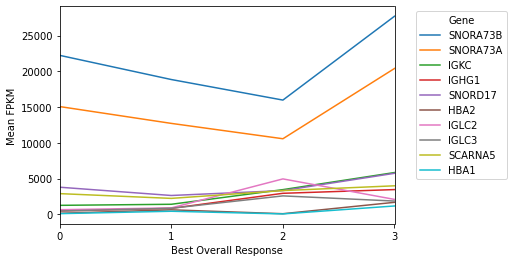

In [27]:
# Visualize the top genes associated with improvment of BOR status
cut_mean_increase_drop = cut_mean_increase.drop(['CR_PD'], axis=1)
cut_mean_increase_t = cut_mean_increase_drop.T

plt.figure(figsize=(20,10))
cut_mean_increase_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2,3]
xi = list(range(len(x)))
plt.xticks(xi, x)


([<matplotlib.axis.XTick at 0x130f4f8d0>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')])

<Figure size 1440x720 with 0 Axes>

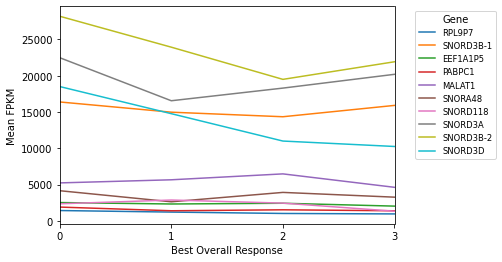

In [28]:
# Visualize the top genes associated with improvment of BOR status
cut_mean_decrease_drop = cut_mean_decrease.drop(['CR_PD'], axis=1)
cut_mean_decrease_t = cut_mean_decrease_drop.T

plt.figure(figsize=(20,10))
cut_mean_decrease_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2,3]
xi = list(range(len(x)))
plt.xticks(xi, x)

#### Which genes are associated with acral tumor type?

In [29]:
acral_data = clinical_fkpm[clinical_fkpm['sample.tumor.type'] == 'acral']
acral_data = acral_data.drop(['subject.id.original', 'sample.tumor.type', 'sample.freetext.anatomic.site', 'timepoint.id',
                                      'meddra.disease.preferred.name', 'treatment.regimen.name', 'bor', 'pfs', 'os', 'subject.id', 
                                      'previous_naive'], axis=1)

# acral_data.head()

In [30]:
# Find genes with the greatest mean exprssion change from PD to CR in the tumor type
acral_mean = acral_data.groupby('bor_numeric').mean()
acral_mean = acral_mean.T

print(acral_mean.columns) # note that there is no data for BOR = 3 (CR))

acral_mean['CR_PD'] = acral_mean[2] - acral_mean[0]
acral_mean.sort_values(by=['CR_PD'], ascending=False, inplace=True) # sort rows

# Select the top 10 genes
acral_mean_increase = acral_mean[:10] # positively associated with improved status
acral_mean_decrease = acral_mean[-10:] # negatively associated with improved status

Int64Index([0, 1, 2], dtype='int64', name='bor_numeric')


([<matplotlib.axis.XTick at 0x130fbc6d8>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')])

<Figure size 1440x720 with 0 Axes>

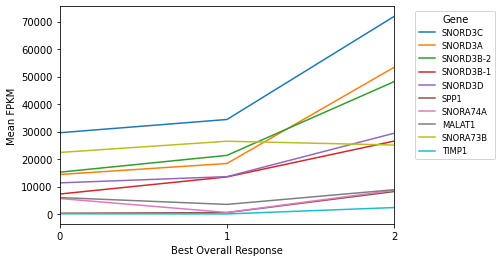

In [31]:
# Visualize the top genes associated with improvment of BOR status
acral_mean_increase_drop = acral_mean_increase.drop(['CR_PD'], axis=1)
acral_mean_increase_t = acral_mean_increase_drop.T

plt.figure(figsize=(20,10))
acral_mean_increase_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2]
xi = list(range(len(x)))
plt.xticks(xi, x)

([<matplotlib.axis.XTick at 0x131188a58>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')])

<Figure size 1440x720 with 0 Axes>

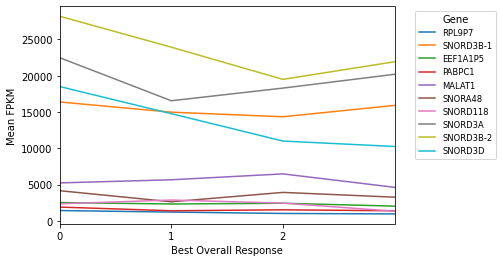

In [32]:
# Visualize the top genes associated with improvment of BOR status
cut_mean_decrease_drop = cut_mean_decrease.drop(['CR_PD'], axis=1)
cut_mean_decrease_t = cut_mean_decrease_drop.T

plt.figure(figsize=(20,10))
cut_mean_decrease_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2]
xi = list(range(len(x)))
plt.xticks(xi, x)

#### Which genes are associated with mucosal tumor type?

In [33]:
muc_data = clinical_fkpm[clinical_fkpm['sample.tumor.type'] == 'mucosal']
muc_data = muc_data.drop(['subject.id.original', 'sample.tumor.type', 'sample.freetext.anatomic.site', 'timepoint.id',
                                      'meddra.disease.preferred.name', 'treatment.regimen.name', 'bor', 'pfs', 'os', 'subject.id', 
                                      'previous_naive'], axis=1)

# muc_data.head()

In [34]:
# Find genes with the greatest mean exprssion change from PD to CR in the tumor type
muc_mean = muc_data.groupby('bor_numeric').mean()
muc_mean = muc_mean.T

print(muc_mean.columns) # note that there is no data for BOR = 3 (CR))

muc_mean['CR_PD'] = muc_mean[2] - muc_mean[0]
muc_mean.sort_values(by=['CR_PD'], ascending=False, inplace=True) # sort rows

# Select the top 10 genes
muc_mean_increase = muc_mean[:10] # positively associated with improved status
muc_mean_decrease = muc_mean[-10:] # negatively associated with improved status

Int64Index([0, 1, 2], dtype='int64', name='bor_numeric')


([<matplotlib.axis.XTick at 0x130fcb4e0>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')])

<Figure size 1440x720 with 0 Axes>

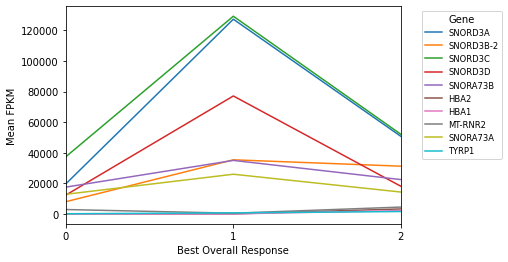

In [35]:
# Visualize the top genes associated with improvment of BOR status
muc_mean_increase_drop = muc_mean_increase.drop(['CR_PD'], axis=1)
muc_mean_increase_t = muc_mean_increase_drop.T

plt.figure(figsize=(20,10))
muc_mean_increase_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2]
xi = list(range(len(x)))
plt.xticks(xi, x)

([<matplotlib.axis.XTick at 0x130fbacc0>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')])

<Figure size 1440x720 with 0 Axes>

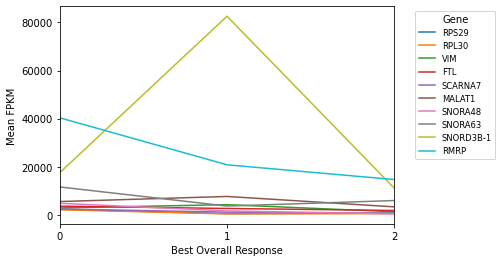

In [36]:
# Visualize the top genes associated with improvment of BOR status
muc_mean_decrease_drop = muc_mean_decrease.drop(['CR_PD'], axis=1)
muc_mean_decrease_t = muc_mean_decrease_drop.T

plt.figure(figsize=(20,10))
muc_mean_decrease_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2]
xi = list(range(len(x)))
plt.xticks(xi, x)

#### Which genes are associated with an unknown tumor type?

In [37]:
unkn_data = clinical_fkpm[clinical_fkpm['sample.tumor.type'] == 'mucosal']
unkn_data = unkn_data.drop(['subject.id.original', 'sample.tumor.type', 'sample.freetext.anatomic.site', 'timepoint.id',
                            'meddra.disease.preferred.name', 'treatment.regimen.name', 'bor', 'pfs', 'os', 'subject.id', 
                            'previous_naive'], axis=1)

# unkn_data.head()

# Find genes with the greatest mean exprssion change from PD to CR in the tumor type
unkn_mean = unkn_data.groupby('bor_numeric').mean()
unkn_mean = unkn_mean.T

print(unkn_mean.columns) # note that there is no data for BOR = 3 (CR))

unkn_mean['CR_PD'] = unkn_mean[2] - unkn_mean[0]
unkn_mean.sort_values(by=['CR_PD'], ascending=False, inplace=True) # sort rows

# Select the top 10 genes
unkn_mean_increase = unkn_mean[:10] # positively associated with improved status
unkn_mean_decrease = unkn_mean[-10:] # negatively associated with improved status

Int64Index([0, 1, 2], dtype='int64', name='bor_numeric')


([<matplotlib.axis.XTick at 0x130daa278>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')])

<Figure size 1440x720 with 0 Axes>

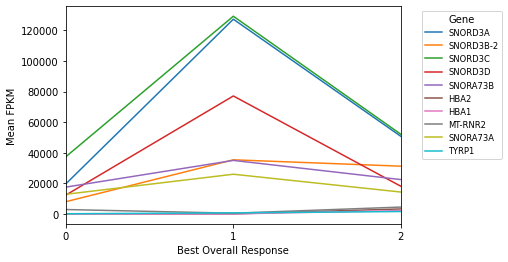

In [38]:
# Visualize the top genes associated with improvment of BOR status
unkn_mean_increase_drop = unkn_mean_increase.drop(['CR_PD'], axis=1)
unkn_mean_increase_t = unkn_mean_increase_drop.T

plt.figure(figsize=(20,10))
unkn_mean_increase_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2]
xi = list(range(len(x)))
plt.xticks(xi, x)

([<matplotlib.axis.XTick at 0x12fbe5ef0>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')])

<Figure size 1440x720 with 0 Axes>

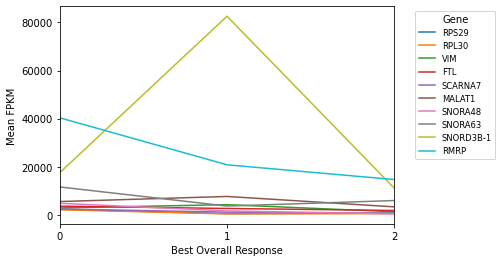

In [39]:
# Visualize the top genes negatively associated with improvment of BOR status
unkn_mean_decrease_drop = unkn_mean_decrease.drop(['CR_PD'], axis=1)
unkn_mean_decrease_t = unkn_mean_decrease_drop.T

plt.figure(figsize=(20,10))
unkn_mean_decrease_t.plot.line()
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('Best Overall Response')
plt.ylabel('Mean FPKM')
x = [0,1,2]
xi = list(range(len(x)))
plt.xticks(xi, x)